# deep learning sentence level models

## V1: IndoBERT mentioned text feature only

In [1]:
import os
import pandas as pd
import torch
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import seaborn as sns
import matplotlib.pyplot as plt

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indobenchmark/indobert-base-p1"
OUTPUT_DIR = "results/V1_IndoBERT"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load data ===
df = pd.read_csv("sentence_level.csv")
df["text"] = df["text"].fillna("")
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["text"].tolist()

# === Dataset ===
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Tokenizer ===
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Class weights ===
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === K-Fold Setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = SentenceDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentenceDataset(val_texts, val_labels, tokenizer)

    # Load model with class weights
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    class_weights_tensor = class_weights_tensor.to(model.classifier.weight.device)
    model.classifier.weight.data = model.classifier.weight.data * class_weights_tensor.unsqueeze(1)

    # Training args
    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)
    pred = preds

    # Decode labels
    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(pred)

    # Save classification report
    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    # Save confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    # Save summary metrics
    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Save average summary
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

# === Plot average confusion matrix
avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0923, 'grad_norm': 9.04847526550293, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0674, 'grad_norm': 5.852016448974609, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0206, 'grad_norm': 8.246490478515625, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.9744940400123596, 'eval_accuracy': 0.5772870662460567, 'eval_f1': 0.4161185125825013, 'eval_precision': 0.38345864661654133, 'eval_recall': 0.476303253028447, 'eval_runtime': 0.5244, 'eval_samples_per_second': 604.489, 'eval_steps_per_second': 76.276, 'epoch': 1.0}
{'loss': 0.9379, 'grad_norm': 5.548410892486572, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.8528, 'grad_norm': 6.260129928588867, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8284, 'grad_norm': 9.115910530090332, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7626765370368958, 'eval_accuracy': 0.6876971608832808, 'eval_f1': 0.6571014658738028, 'eval_precision': 0.6900716845878136, 'eval_recall': 0.6444062899208102, 'eval_runtime': 0.5418, 'eval_samples_per_second': 585.117, 'eval_steps_per_second': 73.832, 'epoch': 2.0}
{'loss': 0.6903, 'grad_norm': 7.639392375946045, 'learning_rate': 1.7811816192560

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0903, 'grad_norm': 8.753742218017578, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0707, 'grad_norm': 7.206368446350098, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0054, 'grad_norm': 8.186260223388672, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0166505575180054, 'eval_accuracy': 0.4889589905362776, 'eval_f1': 0.36926450742240213, 'eval_precision': 0.3320816022158304, 'eval_recall': 0.4533278889342589, 'eval_runtime': 0.4963, 'eval_samples_per_second': 638.708, 'eval_steps_per_second': 80.594, 'epoch': 1.0}
{'loss': 0.9542, 'grad_norm': 6.496032238006592, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.8113, 'grad_norm': 35.17688751220703, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.9435, 'grad_norm': 6.915084362030029, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.845962405204773, 'eval_accuracy': 0.6782334384858044, 'eval_f1': 0.6359649171721543, 'eval_precision': 0.6677302104262607, 'eval_recall': 0.6236759205052139, 'eval_runtime': 0.518, 'eval_samples_per_second': 611.956, 'eval_steps_per_second': 77.218, 'epoch': 2.0}
{'loss': 0.7682, 'grad_norm': 6.455863952636719, 'learning_rate': 1.78118161925601

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0923, 'grad_norm': 8.50872802734375, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0662, 'grad_norm': 4.8806281089782715, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.9914, 'grad_norm': 4.898153781890869, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.9110589027404785, 'eval_accuracy': 0.6025236593059937, 'eval_f1': 0.4583755628574906, 'eval_precision': 0.7308080808080808, 'eval_recall': 0.5255704169944925, 'eval_runtime': 0.5322, 'eval_samples_per_second': 595.689, 'eval_steps_per_second': 75.166, 'epoch': 1.0}
{'loss': 0.8944, 'grad_norm': 5.464879512786865, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.7993, 'grad_norm': 8.252647399902344, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7749, 'grad_norm': 5.625411510467529, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7149591445922852, 'eval

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.093, 'grad_norm': 7.617997646331787, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0642, 'grad_norm': 6.125290870666504, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0169, 'grad_norm': 7.976737976074219, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.966586709022522, 'eval_accuracy': 0.5678233438485805, 'eval_f1': 0.413406952329108, 'eval_precision': 0.3680659670164918, 'eval_recall': 0.4778225806451613, 'eval_runtime': 0.546, 'eval_samples_per_second': 580.563, 'eval_steps_per_second': 73.257, 'epoch': 1.0}
{'loss': 0.8912, 'grad_norm': 9.08425521850586, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.836, 'grad_norm': 10.733771324157715, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8221, 'grad_norm': 6.600358009338379, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8285237550735474, 'eval_accuracy': 0.6561514195583596, 'eval_f1': 0.5928686587601316, 'eval_precision': 0.6943347139425571, 'eval_recall': 0.6023341201153948, 'eval_runtime': 0.5434, 'eval_samples_per_second': 583.311, 'eval_steps_per_second': 73.604, 'epoch': 2.0}
{'loss': 0.6873, 'grad_norm': 8.912344932556152, 'learning_rate': 1.7811816192560176e

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0928, 'grad_norm': 8.653054237365723, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0658, 'grad_norm': 7.378530025482178, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0291, 'grad_norm': 7.4044647216796875, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0017800331115723, 'eval_accuracy': 0.4889589905362776, 'eval_f1': 0.2189265536723164, 'eval_precision': 0.16298633017875921, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4258, 'eval_samples_per_second': 744.488, 'eval_steps_per_second': 93.942, 'epoch': 1.0}
{'loss': 0.9474, 'grad_norm': 6.492986679077148, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.8184, 'grad_norm': 7.414549350738525, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8205, 'grad_norm': 5.997490406036377, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7417582273483276, 'eval_accuracy': 0.722397476340694, 'eval_f1': 0.6895267369454006, 'eval_precision': 0.740574928514627, 'eval_recall': 0.6689450563860477, 'eval_runtime': 0.4339, 'eval_samples_per_second': 730.529, 'eval_steps_per_second': 92.18, 'epoch': 2.0}
{'loss': 0.6829, 'grad_norm': 8.992803573608398, 'learning_rate': 1.781181619256017

In [1]:
import os
import shutil

# Base directory
base_dir = "results/V1_IndoBERT"

# Loop through each fold
for fold in range(1, 6):
    fold_path = os.path.join(base_dir, f"fold_{fold}")
    if not os.path.exists(fold_path):
        print(f"⚠️  Folder not found: {fold_path}")
        continue

    deleted = 0
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                print(f"🗑️  Deleted checkpoint folder: {item_path}")
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    if deleted == 0:
        print(f"ℹ️  No checkpoint folders found in: {fold_path}")


🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_1\checkpoint-159
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_1\checkpoint-318
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_1\checkpoint-477
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_1\checkpoint-636
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_1\checkpoint-795
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_2\checkpoint-159
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_2\checkpoint-318
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_2\checkpoint-477
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_2\checkpoint-636
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_2\checkpoint-795
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_2\checkpoint-954
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_3\checkpoint-1113
🗑️  Deleted checkpoint folder: results/V1_IndoBERT\fold_3\checkpoint-159
🗑️  Deleted checkpoint folder: results/V1_IndoBERT

## V1: CahyaBERT mentioned text feature only

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import seaborn as sns
import matplotlib.pyplot as plt

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "cahya/bert-base-indonesian-1.5G"
OUTPUT_DIR = "results/V1_CahyaBERT"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load data ===
df = pd.read_csv("sentence_level.csv")
texts = df["text"].fillna("").tolist()
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])

# === Dataset ===
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Tokenizer ===
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts
class_weights = class_weights * (len(labels) / class_weights.sum())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda")

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === K-Fold Setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = SentenceDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentenceDataset(val_texts, val_labels, tokenizer)

    # Load model and apply class weights
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model.to("cuda")
    model.classifier.weight.data = model.classifier.weight.data * class_weights_tensor.unsqueeze(1)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)
    pred = preds

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(pred)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (CahyaBERT)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - CahyaBERT)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 49.1791, 'grad_norm': 6326.212890625, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 44.2874, 'grad_norm': 3459.02294921875, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 32.4295, 'grad_norm': 1113.235595703125, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 18.291828155517578, 'eval_accuracy': 0.583596214511041, 'eval_f1': 0.5651148568589229, 'eval_precision': 0.6004213671307945, 'eval_recall': 0.5961607147249676, 'eval_runtime': 0.5406, 'eval_samples_per_second': 586.371, 'eval_steps_per_second': 73.99, 'epoch': 1.0}
{'loss': 34.4164, 'grad_norm': 4941.6005859375, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 31.0279, 'grad_norm': 3439.789794921875, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 33.4572, 'grad_norm': 4547.068359375, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 23.63526725769043, 'eval_accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 54.6426, 'grad_norm': 6090.73876953125, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 37.4519, 'grad_norm': 2940.49609375, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 40.126, 'grad_norm': 1436.8189697265625, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 21.51311683654785, 'eval_accuracy': 0.5173501577287066, 'eval_f1': 0.5131460103276634, 'eval_precision': 0.5984301293155102, 'eval_recall': 0.5572060393472625, 'eval_runtime': 0.5006, 'eval_samples_per_second': 633.25, 'eval_steps_per_second': 79.905, 'epoch': 1.0}
{'loss': 26.4898, 'grad_norm': 2070.095703125, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 27.2999, 'grad_norm': 4192.66357421875, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 25.7015, 'grad_norm': 3167.3828125, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 34.09135818481445, 'eval_accuracy':

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 50.5728, 'grad_norm': 3245.04638671875, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 42.4313, 'grad_norm': 3161.49560546875, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 35.7689, 'grad_norm': 2302.41650390625, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 10.83705997467041, 'eval_accuracy': 0.6876971608832808, 'eval_f1': 0.6737730002218734, 'eval_precision': 0.6823854514774045, 'eval_recall': 0.6671616837136113, 'eval_runtime': 0.5569, 'eval_samples_per_second': 569.196, 'eval_steps_per_second': 71.823, 'epoch': 1.0}
{'loss': 33.5833, 'grad_norm': 5196.30224609375, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 29.8334, 'grad_norm': 1754.2822265625, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 29.9121, 'grad_norm': 1756.71240234375, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 19.097532272338867, 'eval_a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 56.5571, 'grad_norm': 2721.39404296875, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 38.4659, 'grad_norm': 3054.83056640625, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 40.4947, 'grad_norm': 2912.645263671875, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 40.603172302246094, 'eval_accuracy': 0.5867507886435331, 'eval_f1': 0.46247273424189417, 'eval_precision': 0.6439560439560439, 'eval_recall': 0.5286257539994755, 'eval_runtime': 0.5418, 'eval_samples_per_second': 585.042, 'eval_steps_per_second': 73.822, 'epoch': 1.0}
{'loss': 43.7383, 'grad_norm': 2621.87744140625, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 26.2832, 'grad_norm': 3518.46533203125, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 37.6852, 'grad_norm': 3062.520751953125, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 28.427148818969727, 'e

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 82.2661, 'grad_norm': 3901.080322265625, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 44.424, 'grad_norm': 5242.29345703125, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 46.431, 'grad_norm': 2402.420654296875, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 39.559757232666016, 'eval_accuracy': 0.5488958990536278, 'eval_f1': 0.3663613023690046, 'eval_precision': 0.7739085239085238, 'eval_recall': 0.4112804878048781, 'eval_runtime': 0.4439, 'eval_samples_per_second': 714.132, 'eval_steps_per_second': 90.111, 'epoch': 1.0}
{'loss': 39.6152, 'grad_norm': 3305.20263671875, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 33.4658, 'grad_norm': 2194.735595703125, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 31.9048, 'grad_norm': 1298.4979248046875, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 25.07008171081543, 'ev

In [5]:
import os
import shutil

# === Configuration ===
base_dir = "results/V1_CahyaBERT"

# === Deletion Script for checkpoint folders ===
for fold_name in os.listdir(base_dir):
    fold_path = os.path.join(base_dir, fold_name)
    if os.path.isdir(fold_path):
        deleted_count = 0
        for item in os.listdir(fold_path):
            item_path = os.path.join(fold_path, item)
            if os.path.isdir(item_path) and item.startswith("checkpoint-"):
                try:
                    shutil.rmtree(item_path)
                    deleted_count += 1
                except Exception as e:
                    print(f"❌ Failed to delete {item_path}: {e}")
        if deleted_count:
            print(f"✅ Deleted {deleted_count} checkpoint folders from: {fold_path}")
        else:
            print(f"⚠️ No checkpoint folders found in: {fold_path}")


✅ Deleted 5 checkpoint folders from: results/V1_CahyaBERT\fold_1
✅ Deleted 5 checkpoint folders from: results/V1_CahyaBERT\fold_2
✅ Deleted 5 checkpoint folders from: results/V1_CahyaBERT\fold_3
✅ Deleted 9 checkpoint folders from: results/V1_CahyaBERT\fold_4
✅ Deleted 6 checkpoint folders from: results/V1_CahyaBERT\fold_5


## V1: IndoLEM mentioned text feature only

In [1]:
import os
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indolem/indobert-base-uncased"
OUTPUT_DIR = "results/V1_IndoLEM"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load data ===
df = pd.read_csv("sentence_level.csv")
df["text"] = df["text"].fillna("")
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["text"].tolist()

# === Dataset class ===
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (3 * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Weighted Trainer ===
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# === K-Fold Setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = SentenceDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentenceDataset(val_texts, val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = WeightedTrainer(
        class_weights=class_weights_tensor,
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)
    pred = preds

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(pred)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoLEM)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# Save summary and average CM
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoLEM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1344, 'grad_norm': 32.10078430175781, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.12, 'grad_norm': 18.517822265625, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.1045, 'grad_norm': 13.757320404052734, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.0288586616516113, 'eval_accuracy': 0.47318611987381703, 'eval_f1': 0.4728397228397228, 'eval_precision': 0.5374492698047487, 'eval_recall': 0.5142785925244465, 'eval_runtime': 0.5769, 'eval_samples_per_second': 549.488, 'eval_steps_per_second': 69.336, 'epoch': 1.0}
{'loss': 1.0613, 'grad_norm': 12.129722595214844, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9673, 'grad_norm': 20.51998519897461, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.9016, 'grad_norm': 19.325000762939453, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7734035849571228, 'eval

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1025, 'grad_norm': 21.636510848999023, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1184, 'grad_norm': 18.407243728637695, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.08, 'grad_norm': 16.170921325683594, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.016161561012268, 'eval_accuracy': 0.5205047318611987, 'eval_f1': 0.3945050089083823, 'eval_precision': 0.502635046113307, 'eval_recall': 0.414500140209675, 'eval_runtime': 0.5033, 'eval_samples_per_second': 629.875, 'eval_steps_per_second': 79.479, 'epoch': 1.0}
{'loss': 1.0432, 'grad_norm': 16.15192413330078, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.8928, 'grad_norm': 24.444381713867188, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8028, 'grad_norm': 12.628484725952148, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7957717180252075, 'eval

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1192, 'grad_norm': 20.998741149902344, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1084, 'grad_norm': 12.715609550476074, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.1213, 'grad_norm': 20.587465286254883, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.9889001846313477, 'eval_accuracy': 0.5615141955835962, 'eval_f1': 0.4544532765609513, 'eval_precision': 0.6112941176470589, 'eval_recall': 0.4625098347757672, 'eval_runtime': 0.5283, 'eval_samples_per_second': 600.085, 'eval_steps_per_second': 75.721, 'epoch': 1.0}
{'loss': 1.0359, 'grad_norm': 16.055482864379883, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9199, 'grad_norm': 16.4775390625, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8239, 'grad_norm': 20.003986358642578, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7355136275291443, 'eva

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1202, 'grad_norm': 22.871623992919922, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1086, 'grad_norm': 22.75418472290039, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0964, 'grad_norm': 15.198299407958984, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.0524996519088745, 'eval_accuracy': 0.47003154574132494, 'eval_f1': 0.3382248725261429, 'eval_precision': 0.4431476707548889, 'eval_recall': 0.3652766850249147, 'eval_runtime': 0.5571, 'eval_samples_per_second': 569.025, 'eval_steps_per_second': 71.801, 'epoch': 1.0}
{'loss': 1.0035, 'grad_norm': 19.414033889770508, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9873, 'grad_norm': 20.381244659423828, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.9131, 'grad_norm': 13.96874713897705, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.9051327705383301, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1284, 'grad_norm': 25.807157516479492, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1219, 'grad_norm': 24.677719116210938, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0989, 'grad_norm': 13.519064903259277, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0213181972503662, 'eval_accuracy': 0.4921135646687697, 'eval_f1': 0.30740234770289415, 'eval_precision': 0.3089350180505415, 'eval_recall': 0.3680304222397062, 'eval_runtime': 0.4847, 'eval_samples_per_second': 653.969, 'eval_steps_per_second': 82.52, 'epoch': 1.0}
{'loss': 1.0154, 'grad_norm': 16.352994918823242, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9633, 'grad_norm': 24.763978958129883, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.9054, 'grad_norm': 24.001976013183594, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7688893675804138, 'eval_accuracy': 0.6561514195583596, 'eval_f1': 0.6268216139253798, 'eval_precision': 0.6490453436561222, 'eval_recall': 0.6269013899816418, 'eval_runtime': 0.4406, 'eval_samples_per_second': 719.532, 'eval_steps_per_second': 90.793, 'epoch': 2.0}
{'loss': 0.7809, 'grad_norm': 19.821949005126953, 'learning_rate': 1.781181619

In [3]:
import os
import shutil

BASE_DIR = "results/V1_IndoLEM"

for fold in range(1, 6):
    fold_path = os.path.join(BASE_DIR, f"fold_{fold}")
    deleted = 0

    for name in os.listdir(fold_path):
        if name.startswith("checkpoint-"):
            full_path = os.path.join(fold_path, name)
            if os.path.isdir(full_path):
                try:
                    shutil.rmtree(full_path)
                    print(f"✅ Deleted: {full_path}")
                    deleted += 1
                except Exception as e:
                    print(f"❌ Failed to delete {full_path}: {e}")

    if deleted == 0:
        print(f"ℹ️ No checkpoints to delete in {fold_path}")


✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-1113
✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-1272
✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-159
✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-318
✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-477
✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-636
✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-795
✅ Deleted: results/V1_IndoLEM\fold_1\checkpoint-954
✅ Deleted: results/V1_IndoLEM\fold_2\checkpoint-159
✅ Deleted: results/V1_IndoLEM\fold_2\checkpoint-318
✅ Deleted: results/V1_IndoLEM\fold_2\checkpoint-477
✅ Deleted: results/V1_IndoLEM\fold_2\checkpoint-636
✅ Deleted: results/V1_IndoLEM\fold_3\checkpoint-1113
✅ Deleted: results/V1_IndoLEM\fold_3\checkpoint-159
✅ Deleted: results/V1_IndoLEM\fold_3\checkpoint-318
✅ Deleted: results/V1_IndoLEM\fold_3\checkpoint-477
✅ Deleted: results/V1_IndoLEM\fold_3\checkpoint-636
✅ Deleted: results/V1_IndoLEM\fold_3\checkpoint-795
✅ Deleted: results/V1_IndoLEM\fold_3\checkpoint-954
✅ Deleted

## comparison between V1 models


📊 Model Comparison:

           Precision  Recall      F1  Accuracy
CahyaBERT     0.6850  0.6755  0.6631    0.6782
IndoBERT      0.7012  0.7029  0.7003    0.7148
IndoLEM       0.6891  0.6987  0.6883    0.6978


C:\Users\rayssa\AppData\Local\Temp\ipykernel_8032\2231780880.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rayssa\AppData\Local\Temp\ipykernel_8032\2231780880.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("results/V1_Model_Comparison.png")
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


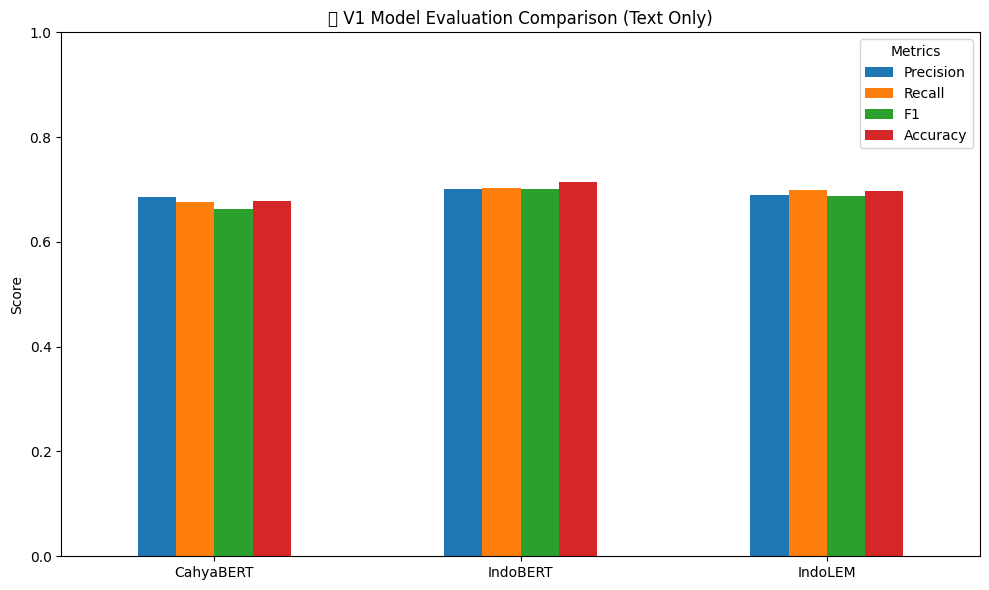

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Define paths to summary files
summary_paths = {
    "CahyaBERT": "results/V1_CahyaBERT/summary.csv",
    "IndoBERT": "results/V1_IndoBERT/summary.csv",
    "IndoLEM": "results/V1_IndoLEM/summary.csv"
}

# Load average row from each summary file
summary_data = {}
for model_name, path in summary_paths.items():
    df = pd.read_csv(path)
    average_row = df.iloc[-1].drop(labels="Fold")  # safely get last row (Average)
    summary_data[model_name] = average_row.values  # store values only

# Convert to DataFrame
metrics = ["Precision", "Recall", "F1", "Accuracy"]
comparison_df = pd.DataFrame(summary_data, index=metrics).T

# Display as table
print("\n📊 Model Comparison:\n")
print(comparison_df.round(4))

# Plot comparison
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("📈 V1 Model Evaluation Comparison (Text Only)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.savefig("results/V1_Model_Comparison.png")
plt.show()


In [2]:
import pandas as pd

# Define paths to your summary CSVs
model_paths = {
    "IndoBERT": "results/V1_IndoBERT/summary.csv",
    "CahyaBERT": "results/V1_CahyaBERT/summary.csv",
    "IndoLEM": "results/V1_IndoLEM/summary.csv"
}

# Load and extract the average row
summary_data = {}
for model_name, path in model_paths.items():
    df = pd.read_csv(path)

    # Standardize 'Fold' column to string
    if "Fold" in df.columns:
        df["Fold"] = df["Fold"].astype(str)
        avg_row = df[df["Fold"].str.lower() == "average"]
        if avg_row.empty:
            avg_row = df.tail(1)
    else:
        avg_row = df.tail(1)

    # Handle possible column name variations
    col_map = {col.lower().replace("-", "").replace("_", ""): col for col in df.columns}
    precision_col = col_map.get("precision", "Precision")
    recall_col = col_map.get("recall", "Recall")
    f1_col = col_map.get("f1score", "F1")  # fallback to "F1" if not "F1-score"
    acc_col = col_map.get("accuracy", "Accuracy")

    summary_data[model_name] = {
        "Precision": avg_row[precision_col].values[0],
        "Recall": avg_row[recall_col].values[0],
        "F1-score": avg_row[f1_col].values[0],
        "Accuracy": avg_row[acc_col].values[0]
    }

# Create and display leaderboard
leaderboard_df = pd.DataFrame.from_dict(summary_data, orient="index")
leaderboard_df = leaderboard_df.sort_values(by="F1-score", ascending=False)

print("🏆 V1 Model Leaderboard (Text-only, Sentence Level):")
print(leaderboard_df.round(4))


🏆 V1 Model Leaderboard (Text-only, Sentence Level):
           Precision  Recall  F1-score  Accuracy
IndoBERT      0.7012  0.7029    0.7003    0.7148
IndoLEM       0.6891  0.6987    0.6883    0.6978
CahyaBERT     0.6850  0.6755    0.6631    0.6782


## V2: IndoBERT Contextual Features (with text_prev and text_next but filtered)

meaning only those sentences mention the same character as the current one (to avoid noises)

In [3]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv("sentence_level.csv")
df["aliases"] = df["aliases"].apply(eval)  # make sure aliases are parsed from strings to lists

# Helper to check if alias appears in the text
def contains_alias(text, aliases):
    if not isinstance(text, str): return False
    return any(re.search(rf"\b{re.escape(alias)}\b", text, flags=re.IGNORECASE) for alias in aliases)

# Construct filtered context
filtered_contexts = []
for _, row in df.iterrows():
    aliases = row["aliases"]
    parts = []

    if contains_alias(row["text_prev"], aliases):
        parts.append(row["text_prev"])
    
    parts.append(row["text"])

    if contains_alias(row["text_next"], aliases):
        parts.append(row["text_next"])
    
    filtered_contexts.append(" [SEP] ".join(parts))

# Add new column and save
df["bert_context_filtered"] = filtered_contexts
df.to_csv("sentence_level.csv", index=False)  # overwrite or save as new if you want to keep the original

print("✅ 'bert_context_filtered' column added and CSV updated.")


✅ 'bert_context_filtered' column added and CSV updated.


In [1]:
import os
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indobenchmark/indobert-base-p1"
OUTPUT_DIR = "results/V2_IndoBERT"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seeding ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load and prepare data ===
df = pd.read_csv("sentence_level.csv")
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")
texts = df["bert_context_filtered"].tolist()
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])

# === Dataset class ===
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (3 * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

# === Tokenizer ===
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")
    
    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = SentenceDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentenceDataset(val_texts, val_labels, tokenizer)

    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.classifier.weight.data = model.classifier.weight.data * class_weights_tensor.to(device).unsqueeze(1)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT V2 Filtered)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Save summary
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

# === Save avg confusion matrix
avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT V2 Filtered)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ V2 IndoBERT (Filtered Context) 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0688, 'grad_norm': 13.819631576538086, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9468, 'grad_norm': 12.554306030273438, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7549, 'grad_norm': 12.005807876586914, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7198473215103149, 'eval_accuracy': 0.7066246056782335, 'eval_f1': 0.6803868204955256, 'eval_precision': 0.7291900215583617, 'eval_recall': 0.663312785646465, 'eval_runtime': 0.7286, 'eval_samples_per_second': 435.096, 'eval_steps_per_second': 54.902, 'epoch': 1.0}
{'loss': 0.5931, 'grad_norm': 9.561144828796387, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5834, 'grad_norm': 12.15377426147461, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6151, 'grad_norm': 21.660696029663086, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6393678188323975, 'e

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0231, 'grad_norm': 14.514623641967773, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0195, 'grad_norm': 9.889723777770996, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7893, 'grad_norm': 7.752313137054443, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7265989184379578, 'eval_accuracy': 0.7097791798107256, 'eval_f1': 0.6983277442249012, 'eval_precision': 0.7314529352388521, 'eval_recall': 0.6958863629282339, 'eval_runtime': 0.6737, 'eval_samples_per_second': 470.51, 'eval_steps_per_second': 59.37, 'epoch': 1.0}
{'loss': 0.6613, 'grad_norm': 12.939777374267578, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5748, 'grad_norm': 14.347000122070312, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5962, 'grad_norm': 10.386275291442871, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8068106174468994, 'ev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0279, 'grad_norm': 12.25739574432373, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9956, 'grad_norm': 7.175156116485596, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7683, 'grad_norm': 14.510546684265137, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6321021318435669, 'eval_accuracy': 0.7160883280757098, 'eval_f1': 0.6972400566851444, 'eval_precision': 0.7364285714285713, 'eval_recall': 0.6935811696826645, 'eval_runtime': 0.8327, 'eval_samples_per_second': 380.682, 'eval_steps_per_second': 48.036, 'epoch': 1.0}
{'loss': 0.5639, 'grad_norm': 8.524900436401367, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6188, 'grad_norm': 14.502908706665039, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5338, 'grad_norm': 7.605208396911621, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5563673377037048, 'ev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0584, 'grad_norm': 13.251476287841797, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9855, 'grad_norm': 12.760563850402832, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8062, 'grad_norm': 6.872758388519287, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7857320308685303, 'eval_accuracy': 0.6782334384858044, 'eval_f1': 0.654390447137984, 'eval_precision': 0.6564522746986471, 'eval_recall': 0.6528488067138736, 'eval_runtime': 0.8544, 'eval_samples_per_second': 371.022, 'eval_steps_per_second': 46.817, 'epoch': 1.0}
{'loss': 0.5634, 'grad_norm': 8.07042407989502, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5132, 'grad_norm': 8.920418739318848, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6635, 'grad_norm': 13.046136856079102, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6527907848358154, 'eva

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0563, 'grad_norm': 15.889610290527344, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9611, 'grad_norm': 7.220082759857178, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8154, 'grad_norm': 6.85150671005249, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7028224468231201, 'eval_accuracy': 0.7003154574132492, 'eval_f1': 0.676175002876052, 'eval_precision': 0.702596618357488, 'eval_recall': 0.6618541830579595, 'eval_runtime': 0.6958, 'eval_samples_per_second': 455.584, 'eval_steps_per_second': 57.487, 'epoch': 1.0}
{'loss': 0.64, 'grad_norm': 6.792282581329346, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5241, 'grad_norm': 19.710649490356445, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6495, 'grad_norm': 15.502204895019531, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.603521466255188, 'eval_ac

In [2]:
import os
import shutil

base_dir = "results/V2_IndoBERT"

for fold in os.listdir(base_dir):
    fold_path = os.path.join(base_dir, fold)
    if os.path.isdir(fold_path) and fold.startswith("fold_"):
        deleted = 0
        for item in os.listdir(fold_path):
            item_path = os.path.join(fold_path, item)
            if os.path.isdir(item_path) and item.startswith("checkpoint"):
                try:
                    shutil.rmtree(item_path)
                    deleted += 1
                except Exception as e:
                    print(f"❌ Failed to delete {item_path}: {e}")
        print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 7 checkpoint folders in: results/V2_IndoBERT\fold_1
✅ Deleted 9 checkpoint folders in: results/V2_IndoBERT\fold_2
✅ Deleted 6 checkpoint folders in: results/V2_IndoBERT\fold_3
✅ Deleted 5 checkpoint folders in: results/V2_IndoBERT\fold_4
✅ Deleted 4 checkpoint folders in: results/V2_IndoBERT\fold_5


## V2: CahyaBERT Contextual Features (with text_prev and text_next but filtered)

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "cahya/bert-base-indonesian-1.5G"
OUTPUT_DIR = "results/V2_CahyaBERT"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed setup ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load dataset ===
df = pd.read_csv("sentence_level.csv")
df["text"] = df["text"].fillna("")
df["text_prev"] = df["text_prev"].fillna("")
df["text_next"] = df["text_next"].fillna("")

# Filter context: only include prev/next if they mention the same person
def contains_alias(text, aliases):
    return any(alias.lower() in text.lower() for alias in aliases)

df["aliases"] = df["aliases"].apply(eval)
filtered_contexts = []

for _, row in df.iterrows():
    prev = row["text_prev"]
    current = row["text"]
    next_ = row["text_next"]
    aliases = row["aliases"]

    prev_included = contains_alias(prev, aliases)
    next_included = contains_alias(next_, aliases)

    parts = []
    if prev_included:
        parts.append(prev)
    parts.append(current)
    if next_included:
        parts.append(next_)

    filtered_contexts.append(" [SEP] ".join(parts))

df["bert_context_filtered"] = filtered_contexts

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["type"])
texts = df["bert_context_filtered"].tolist()
labels = df["label"].tolist()

# === Compute class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# === Dataset class ===
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = SentenceDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentenceDataset(val_texts, val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model.classifier.weight.data = model.classifier.weight.data.to(class_weights_tensor.device) * class_weights_tensor.unsqueeze(1)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    # Classification Report
    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    # Confusion Matrix
    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (CahyaBERT V2)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1-score": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Save summary and average
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

# === Save Average Confusion Matrix
avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (CahyaBERT V2)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ CahyaBERT V2 training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0196, 'grad_norm': 13.76442813873291, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.8799, 'grad_norm': 12.489405632019043, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7595, 'grad_norm': 14.188125610351562, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.710380494594574, 'eval_accuracy': 0.7097791798107256, 'eval_f1': 0.6657278401997503, 'eval_precision': 0.7317434705494407, 'eval_recall': 0.6528113269738817, 'eval_runtime': 0.8839, 'eval_samples_per_second': 358.634, 'eval_steps_per_second': 45.253, 'epoch': 1.0}
{'loss': 0.59, 'grad_norm': 13.621402740478516, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5519, 'grad_norm': 7.31398868560791, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5628, 'grad_norm': 11.928994178771973, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6032760143280029, 'eval

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0248, 'grad_norm': 13.487857818603516, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9804, 'grad_norm': 9.098334312438965, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7362, 'grad_norm': 6.735515117645264, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7513902187347412, 'eval_accuracy': 0.7476340694006309, 'eval_f1': 0.7309186336840217, 'eval_precision': 0.766479893732641, 'eval_recall': 0.7305783362113214, 'eval_runtime': 0.7104, 'eval_samples_per_second': 446.223, 'eval_steps_per_second': 56.306, 'epoch': 1.0}
{'loss': 0.6407, 'grad_norm': 20.954145431518555, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.4991, 'grad_norm': 27.352998733520508, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5468, 'grad_norm': 8.782502174377441, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7227463126182556, 'ev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0496, 'grad_norm': 12.454103469848633, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9458, 'grad_norm': 6.748836040496826, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7545, 'grad_norm': 12.04242992401123, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6627793908119202, 'eval_accuracy': 0.7255520504731862, 'eval_f1': 0.714451394284389, 'eval_precision': 0.7422257863316403, 'eval_recall': 0.7032520325203251, 'eval_runtime': 0.8246, 'eval_samples_per_second': 384.433, 'eval_steps_per_second': 48.509, 'epoch': 1.0}
{'loss': 0.5343, 'grad_norm': 8.593549728393555, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.563, 'grad_norm': 11.387507438659668, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5202, 'grad_norm': 14.601458549499512, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5288688540458679, 'eva

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0508, 'grad_norm': 12.402264595031738, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9527, 'grad_norm': 11.594746589660645, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.755, 'grad_norm': 7.986008167266846, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6669558882713318, 'eval_accuracy': 0.722397476340694, 'eval_f1': 0.6948456029118234, 'eval_precision': 0.7162701893397538, 'eval_recall': 0.6830579596118541, 'eval_runtime': 0.8261, 'eval_samples_per_second': 383.752, 'eval_steps_per_second': 48.423, 'epoch': 1.0}
{'loss': 0.508, 'grad_norm': 7.848806381225586, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.4681, 'grad_norm': 11.336015701293945, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6235, 'grad_norm': 13.389108657836914, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6782285571098328, 'eva

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-1.5G and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.046, 'grad_norm': 12.971290588378906, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.8792, 'grad_norm': 7.982390880584717, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7629, 'grad_norm': 9.173330307006836, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6514288187026978, 'eval_accuracy': 0.7097791798107256, 'eval_f1': 0.6896825396825396, 'eval_precision': 0.7424487651077246, 'eval_recall': 0.6855527143981117, 'eval_runtime': 0.7042, 'eval_samples_per_second': 450.172, 'eval_steps_per_second': 56.804, 'epoch': 1.0}
{'loss': 0.5989, 'grad_norm': 3.119967222213745, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5298, 'grad_norm': 14.369967460632324, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5642, 'grad_norm': 13.152920722961426, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5751469731330872, 'ev

In [4]:
import os
import shutil

base_path = "results/V2_CahyaBERT"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 7 checkpoint folders in: results/V2_CahyaBERT\fold_1
✅ Deleted 3 checkpoint folders in: results/V2_CahyaBERT\fold_2
✅ Deleted 7 checkpoint folders in: results/V2_CahyaBERT\fold_3
✅ Deleted 10 checkpoint folders in: results/V2_CahyaBERT\fold_4
✅ Deleted 4 checkpoint folders in: results/V2_CahyaBERT\fold_5


## V2: IndoLEM Contextual Features (with text_prev and text_next but filtered)

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
import random
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuration ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indolem/indobert-base-uncased"
OUTPUT_DIR = "results/V2_IndoLEM"
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed setup ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load dataset ===
df = pd.read_csv("sentence_level.csv")
df["text"] = df["text"].fillna("")
df["text_prev"] = df["text_prev"].fillna("")
df["text_next"] = df["text_next"].fillna("")
df["aliases"] = df["aliases"].apply(eval)

# Filter context: only include prev/next if they mention the same aliases
def contains_alias(text, aliases):
    return any(alias.lower() in text.lower() for alias in aliases)

filtered_contexts = []
for _, row in df.iterrows():
    prev, current, next_ = row["text_prev"], row["text"], row["text_next"]
    aliases = row["aliases"]

    parts = []
    if contains_alias(prev, aliases):
        parts.append(prev)
    parts.append(current)
    if contains_alias(next_, aliases):
        parts.append(next_)

    filtered_contexts.append(" [SEP] ".join(parts))

df["bert_context_filtered"] = filtered_contexts

# === Encode labels ===
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["type"])
texts = df["bert_context_filtered"].tolist()
labels = df["label"].tolist()

# === Class weights ===
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# === Dataset class ===
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# === Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# === Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# === K-Fold setup ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = SentenceDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentenceDataset(val_texts, val_labels, tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model.classifier.weight.data = model.classifier.weight.data.to(class_weights_tensor.device) * class_weights_tensor.unsqueeze(1)

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Evaluate
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true_labels = np.array(val_labels)
    pred_labels = preds

    decoded_true = label_encoder.inverse_transform(true_labels)
    decoded_pred = label_encoder.inverse_transform(pred_labels)

    # Classification Report
    report = classification_report(decoded_true, decoded_pred, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    # Confusion Matrix
    cm = confusion_matrix(decoded_true, decoded_pred, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoLEM V2)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1-score": macro["f1-score"],
        "Accuracy": accuracy_score(decoded_true, decoded_pred)
    })

# === Save summary and average
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

# === Save Average Confusion Matrix
avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (IndoLEM V2)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ IndoLEM V2 training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1134, 'grad_norm': 25.48870277404785, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0834, 'grad_norm': 13.92485237121582, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.9979, 'grad_norm': 9.791160583496094, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.9404793381690979, 'eval_accuracy': 0.5362776025236593, 'eval_f1': 0.3368205228271217, 'eval_precision': 0.8126756963966266, 'eval_recall': 0.3960144374968227, 'eval_runtime': 0.704, 'eval_samples_per_second': 450.259, 'eval_steps_per_second': 56.815, 'epoch': 1.0}
{'loss': 0.9545, 'grad_norm': 15.3212890625, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.7539, 'grad_norm': 22.985267639160156, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7437, 'grad_norm': 25.097070693969727, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7167768478393555, 'eval_ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0706, 'grad_norm': 22.521215438842773, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0794, 'grad_norm': 19.040523529052734, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0127, 'grad_norm': 13.306792259216309, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.9874037504196167, 'eval_accuracy': 0.5205047318611987, 'eval_f1': 0.38216427655383994, 'eval_precision': 0.5903049463215438, 'eval_recall': 0.42002587729439606, 'eval_runtime': 0.6638, 'eval_samples_per_second': 477.586, 'eval_steps_per_second': 60.263, 'epoch': 1.0}
{'loss': 0.9559, 'grad_norm': 16.5935115814209, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.7623, 'grad_norm': 39.226619720458984, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7345, 'grad_norm': 17.029327392578125, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8026914596557617,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0568, 'grad_norm': 25.201854705810547, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0736, 'grad_norm': 26.295791625976562, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0195, 'grad_norm': 16.82146453857422, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.9541305303573608, 'eval_accuracy': 0.5173501577287066, 'eval_f1': 0.3378489982553188, 'eval_precision': 0.555324074074074, 'eval_recall': 0.38645423551009705, 'eval_runtime': 0.8195, 'eval_samples_per_second': 386.841, 'eval_steps_per_second': 48.813, 'epoch': 1.0}
{'loss': 0.9542, 'grad_norm': 20.414514541625977, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.8489, 'grad_norm': 33.94023513793945, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.731, 'grad_norm': 19.107378005981445, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6920335292816162, 'e

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1014, 'grad_norm': 23.84137725830078, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.066, 'grad_norm': 22.2957706451416, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0288, 'grad_norm': 24.079500198364258, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.0946004390716553, 'eval_accuracy': 0.4889589905362776, 'eval_f1': 0.2189265536723164, 'eval_precision': 0.16298633017875921, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.8072, 'eval_samples_per_second': 392.707, 'eval_steps_per_second': 49.553, 'epoch': 1.0}
{'loss': 0.9774, 'grad_norm': 12.48025894165039, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9002, 'grad_norm': 17.249780654907227, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7991, 'grad_norm': 13.921574592590332, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7138863205909729, 'eval_accuracy': 0.6845425867507886, 'eval_f1': 0.6525377359728739, 'eval_precision': 0.6747007894066718, 'eval_recall': 0.6448498557566221, 'eval_runtime': 0.8004, 'eval_samples_per_second': 396.06, 'eval_steps_per_second': 49.976, 'epoch': 2.0}
{'loss': 0.6648, 'grad_norm': 14.836301803588867, 'learning_rate': 1.7811816192

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0902, 'grad_norm': 19.747217178344727, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0777, 'grad_norm': 72.66868591308594, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0326, 'grad_norm': 51.22834777832031, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.0079652070999146, 'eval_accuracy': 0.5078864353312302, 'eval_f1': 0.26901404065875906, 'eval_precision': 0.7777777777777778, 'eval_recall': 0.35823170731707316, 'eval_runtime': 0.722, 'eval_samples_per_second': 439.082, 'eval_steps_per_second': 55.405, 'epoch': 1.0}
{'loss': 0.9916, 'grad_norm': 13.493927001953125, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9281, 'grad_norm': 18.505474090576172, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8531, 'grad_norm': 17.345428466796875, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6852359771728516, 

In [2]:
import os
import shutil

base_path = "results/V2_IndoLEM"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 6 checkpoint folders in: results/V2_IndoLEM\fold_1
✅ Deleted 8 checkpoint folders in: results/V2_IndoLEM\fold_2
✅ Deleted 6 checkpoint folders in: results/V2_IndoLEM\fold_3
✅ Deleted 8 checkpoint folders in: results/V2_IndoLEM\fold_4
✅ Deleted 9 checkpoint folders in: results/V2_IndoLEM\fold_5


## comparison between V2 models

🏆 V2 Model Leaderboard (Contextual Filtered Input):
              Precision  Recall  F1-score  Accuracy
CahyaBERT V2     0.7764  0.7679    0.7678    0.7798
IndoLEM V2       0.7670  0.7616    0.7620    0.7741
IndoBERT V2      0.7687  0.7529    0.7588    0.7722


C:\Users\rayssa\AppData\Local\Temp\ipykernel_49092\1042854244.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rayssa\AppData\Local\Temp\ipykernel_49092\1042854244.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("results/V2_Model_Comparison.png")
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


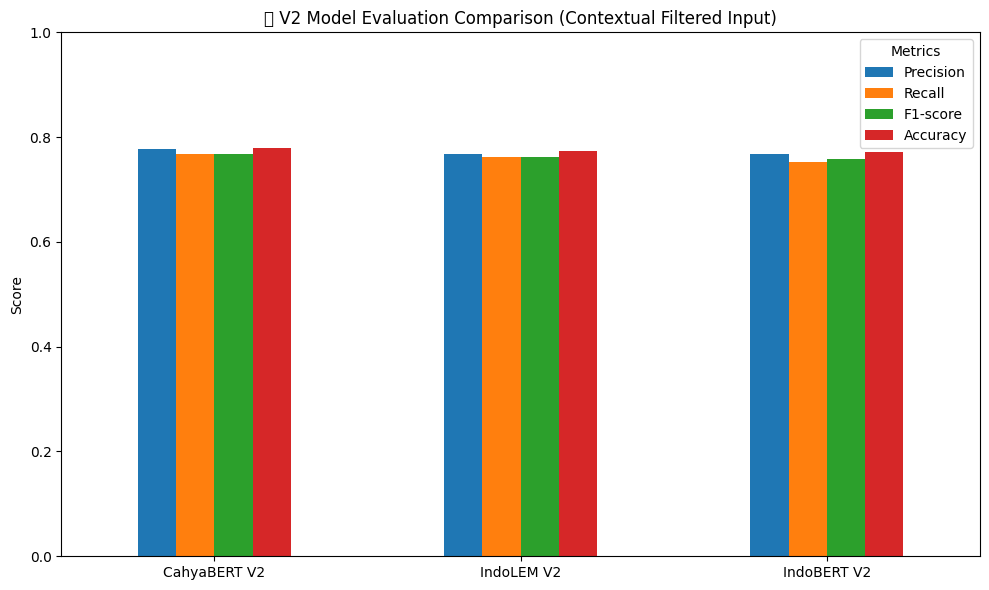

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# === V2 model paths ===
model_paths = {
    "IndoBERT V2": "results/V2_IndoBERT/summary.csv",
    "CahyaBERT V2": "results/V2_CahyaBERT/summary.csv",
    "IndoLEM V2": "results/V2_IndoLEM/summary.csv"
}

summary_data = {}

for model_name, path in model_paths.items():
    df = pd.read_csv(path)

    # Standardize Fold column
    if "Fold" in df.columns:
        df["Fold"] = df["Fold"].astype(str)
        avg_row = df[df["Fold"].str.lower() == "average"]
        if avg_row.empty:
            avg_row = df.tail(1)
    else:
        avg_row = df.tail(1)

    # Normalize columns
    col_map = {col.lower().replace("-", "").replace("_", ""): col for col in df.columns}
    precision_col = col_map.get("precision")
    recall_col = col_map.get("recall")
    acc_col = col_map.get("accuracy")

    # Flexibly handle F1 column names
    f1_col = None
    for key in ["f1score", "f1", "f1_score"]:
        if key in col_map:
            f1_col = col_map[key]
            break

    if not all([precision_col, recall_col, f1_col, acc_col]):
        print(f"⚠️ Skipping {model_name}: Missing columns in {path}")
        continue

    summary_data[model_name] = {
        "Precision": avg_row[precision_col].values[0],
        "Recall": avg_row[recall_col].values[0],
        "F1-score": avg_row[f1_col].values[0],
        "Accuracy": avg_row[acc_col].values[0]
    }

# === Create leaderboard DataFrame ===
leaderboard_df = pd.DataFrame.from_dict(summary_data, orient="index")
leaderboard_df = leaderboard_df.sort_values(by="F1-score", ascending=False)

# === Print leaderboard ===
print("🏆 V2 Model Leaderboard (Contextual Filtered Input):")
print(leaderboard_df.round(4))

# === Plot chart ===
leaderboard_df.plot(kind='bar', figsize=(10, 6))
plt.title("📈 V2 Model Evaluation Comparison (Contextual Filtered Input)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.savefig("results/V2_Model_Comparison.png")
plt.show()


## V3: IndoBERT Mentioned Text + Numerical Features

In [1]:
# === IndoBERT V3: Mentioned Text + Numeric Features + Class Weights ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indobenchmark/indobert-base-p1"
OUTPUT_DIR = "results/V3_IndoBERT_Numeric"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["text"] = df["text"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["text"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0869, 'grad_norm': 13.54738998413086, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.967, 'grad_norm': 11.902423858642578, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8656, 'grad_norm': 12.964700698852539, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.8169539570808411, 'eval_accuracy': 0.580441640378549, 'eval_f1': 0.5827121124847999, 'eval_precision': 0.5999703355818463, 'eval_recall': 0.6137175898366846, 'eval_runtime': 0.5856, 'eval_samples_per_second': 541.312, 'eval_steps_per_second': 68.304, 'epoch': 1.0}
{'loss': 0.6168, 'grad_norm': 14.684208869934082, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6669, 'grad_norm': 27.388879776000977, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6547, 'grad_norm': 35.53197479248047, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5966706275939941, 'ev

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0782, 'grad_norm': 13.138199806213379, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0466, 'grad_norm': 12.053934097290039, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8627, 'grad_norm': 11.64215087890625, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7891985774040222, 'eval_accuracy': 0.7003154574132492, 'eval_f1': 0.6856383599745005, 'eval_precision': 0.6817380231073095, 'eval_recall': 0.6913356980391964, 'eval_runtime': 0.5066, 'eval_samples_per_second': 625.728, 'eval_steps_per_second': 78.956, 'epoch': 1.0}
{'loss': 0.7385, 'grad_norm': 22.109407424926758, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6883, 'grad_norm': 20.538969039916992, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6241, 'grad_norm': 10.175786018371582, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.907014787197113, '

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1255, 'grad_norm': 12.357208251953125, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0075, 'grad_norm': 8.366847038269043, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8915, 'grad_norm': 12.598222732543945, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7091925144195557, 'eval_accuracy': 0.7034700315457413, 'eval_f1': 0.7028411782204209, 'eval_precision': 0.697485119454547, 'eval_recall': 0.7291142145292421, 'eval_runtime': 0.5543, 'eval_samples_per_second': 571.883, 'eval_steps_per_second': 72.162, 'epoch': 1.0}
{'loss': 0.6889, 'grad_norm': 12.103987693786621, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.7156, 'grad_norm': 7.856700897216797, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.594, 'grad_norm': 12.449953079223633, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6756524443626404, 'ev

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1438, 'grad_norm': 13.138566970825195, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0166, 'grad_norm': 12.4723539352417, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8645, 'grad_norm': 12.29377555847168, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.8130695223808289, 'eval_accuracy': 0.6656151419558359, 'eval_f1': 0.6414777886890679, 'eval_precision': 0.6485964507902627, 'eval_recall': 0.6380966430632048, 'eval_runtime': 0.5464, 'eval_samples_per_second': 580.203, 'eval_steps_per_second': 73.212, 'epoch': 1.0}
{'loss': 0.635, 'grad_norm': 14.578392028808594, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5934, 'grad_norm': 15.735970497131348, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.677, 'grad_norm': 6.026862144470215, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.78760826587677, 'eval_a

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.146, 'grad_norm': 16.929889678955078, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0292, 'grad_norm': 8.647910118103027, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8849, 'grad_norm': 12.90658950805664, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7414966225624084, 'eval_accuracy': 0.6876971608832808, 'eval_f1': 0.6729469334157511, 'eval_precision': 0.6691540911489761, 'eval_recall': 0.684087332808812, 'eval_runtime': 0.4238, 'eval_samples_per_second': 747.978, 'eval_steps_per_second': 94.382, 'epoch': 1.0}
{'loss': 0.7049, 'grad_norm': 5.417114734649658, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6231, 'grad_norm': 8.126116752624512, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7367, 'grad_norm': 16.611093521118164, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6634737849235535, 'eval

In [2]:
import os
import shutil

base_path = "results/V3_IndoBERT"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 5 checkpoint folders in: results/V3_IndoBERT\fold_1
✅ Deleted 3 checkpoint folders in: results/V3_IndoBERT\fold_2
✅ Deleted 3 checkpoint folders in: results/V3_IndoBERT\fold_3
✅ Deleted 6 checkpoint folders in: results/V3_IndoBERT\fold_4
✅ Deleted 4 checkpoint folders in: results/V3_IndoBERT\fold_5


## V3: CahyaBERT Mentioned Text + Numerical Features

In [1]:
# === IndoBERT V3: Mentioned Text + Numeric Features + Class Weights ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "cahya/bert-base-indonesian-1.5G"
OUTPUT_DIR = "results/V3_CahyaBERT_1.5G"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["text"] = df["text"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["text"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0933, 'grad_norm': 14.554683685302734, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9583, 'grad_norm': 9.952895164489746, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8562, 'grad_norm': 18.587928771972656, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7885304093360901, 'eval_accuracy': 0.6624605678233438, 'eval_f1': 0.652300785634119, 'eval_precision': 0.6643929513578875, 'eval_recall': 0.6824514882724037, 'eval_runtime': 0.5223, 'eval_samples_per_second': 606.976, 'eval_steps_per_second': 76.59, 'epoch': 1.0}
{'loss': 0.6216, 'grad_norm': 12.46650218963623, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.7013, 'grad_norm': 15.995356559753418, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6563, 'grad_norm': 18.06431007385254, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6139073967933655, 'eva

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1095, 'grad_norm': 13.028265953063965, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0473, 'grad_norm': 14.117859840393066, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8965, 'grad_norm': 11.90977668762207, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7785130739212036, 'eval_accuracy': 0.7003154574132492, 'eval_f1': 0.6900426742532005, 'eval_precision': 0.6975459911630125, 'eval_recall': 0.7037135065373786, 'eval_runtime': 0.4906, 'eval_samples_per_second': 646.164, 'eval_steps_per_second': 81.535, 'epoch': 1.0}
{'loss': 0.7129, 'grad_norm': 18.832508087158203, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6508, 'grad_norm': 18.66231346130371, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6224, 'grad_norm': 8.625741004943848, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.9126388430595398, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1207, 'grad_norm': 12.864082336425781, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0297, 'grad_norm': 9.068153381347656, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8674, 'grad_norm': 14.211169242858887, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.681080162525177, 'eval_accuracy': 0.7129337539432177, 'eval_f1': 0.7058103640382121, 'eval_precision': 0.7047200592092233, 'eval_recall': 0.708661159192237, 'eval_runtime': 0.5342, 'eval_samples_per_second': 593.383, 'eval_steps_per_second': 74.875, 'epoch': 1.0}
{'loss': 0.6803, 'grad_norm': 14.063643455505371, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6934, 'grad_norm': 8.87860107421875, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6114, 'grad_norm': 8.855063438415527, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.626054048538208, 'eval_

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0867, 'grad_norm': 12.863022804260254, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9837, 'grad_norm': 13.48119831085205, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8389, 'grad_norm': 12.77197265625, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.813239336013794, 'eval_accuracy': 0.6908517350157729, 'eval_f1': 0.6764213699754383, 'eval_precision': 0.6719618477146403, 'eval_recall': 0.6831202465250459, 'eval_runtime': 0.5378, 'eval_samples_per_second': 589.439, 'eval_steps_per_second': 74.377, 'epoch': 1.0}
{'loss': 0.6272, 'grad_norm': 13.717374801635742, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5325, 'grad_norm': 17.7235164642334, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7106, 'grad_norm': 21.72113800048828, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8060924410820007, 'eval_ac

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0964, 'grad_norm': 12.48635196685791, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9691, 'grad_norm': 8.164434432983398, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8936, 'grad_norm': 10.852904319763184, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.735353410243988, 'eval_accuracy': 0.6908517350157729, 'eval_f1': 0.6781336451755111, 'eval_precision': 0.6774883538582168, 'eval_recall': 0.684424993443483, 'eval_runtime': 0.45, 'eval_samples_per_second': 704.44, 'eval_steps_per_second': 88.888, 'epoch': 1.0}
{'loss': 0.6764, 'grad_norm': 8.417146682739258, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6446, 'grad_norm': 10.024173736572266, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6697, 'grad_norm': 12.790691375732422, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6898950338363647, 'eval_a

In [2]:
import os
import shutil

base_path = "results/V3_CahyaBERT"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 5 checkpoint folders in: results/V3_CahyaBERT\fold_1
✅ Deleted 5 checkpoint folders in: results/V3_CahyaBERT\fold_2
✅ Deleted 3 checkpoint folders in: results/V3_CahyaBERT\fold_3
✅ Deleted 6 checkpoint folders in: results/V3_CahyaBERT\fold_4
✅ Deleted 4 checkpoint folders in: results/V3_CahyaBERT\fold_5


## V3: IndoLEM Mentioned Text + Numerical Features

In [3]:
# === IndoBERT V3: Mentioned Text + Numeric Features + Class Weights ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indolem/indobert-base-uncased"
OUTPUT_DIR = "results/V3_IndoLEM"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["text"] = df["text"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["text"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1321, 'grad_norm': 22.171367645263672, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1019, 'grad_norm': 13.788304328918457, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0955, 'grad_norm': 13.875900268554688, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.007570505142212, 'eval_accuracy': 0.5520504731861199, 'eval_f1': 0.4041362661941353, 'eval_precision': 0.643993122716527, 'eval_recall': 0.4394623819901902, 'eval_runtime': 0.5247, 'eval_samples_per_second': 604.164, 'eval_steps_per_second': 76.235, 'epoch': 1.0}
{'loss': 1.0407, 'grad_norm': 11.864604949951172, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9604, 'grad_norm': 15.828473091125488, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.9251, 'grad_norm': 18.840049743652344, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.743929922580719, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1247, 'grad_norm': 25.902536392211914, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1312, 'grad_norm': 21.953693389892578, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.1015, 'grad_norm': 17.735368728637695, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.030206561088562, 'eval_accuracy': 0.5299684542586751, 'eval_f1': 0.35831410118460144, 'eval_precision': 0.529642496094109, 'eval_recall': 0.4000242702127415, 'eval_runtime': 0.5048, 'eval_samples_per_second': 628.016, 'eval_steps_per_second': 79.245, 'epoch': 1.0}
{'loss': 1.0925, 'grad_norm': 12.33425235748291, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9787, 'grad_norm': 21.98346710205078, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.935, 'grad_norm': 15.13537311553955, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8287168741226196, 'eva

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1188, 'grad_norm': 31.887802124023438, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1092, 'grad_norm': 22.25083351135254, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.1209, 'grad_norm': 15.925354957580566, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.011908769607544, 'eval_accuracy': 0.5772870662460567, 'eval_f1': 0.47873557368898245, 'eval_precision': 0.5659095679615516, 'eval_recall': 0.4798190401258851, 'eval_runtime': 0.5361, 'eval_samples_per_second': 591.357, 'eval_steps_per_second': 74.619, 'epoch': 1.0}
{'loss': 1.0643, 'grad_norm': 21.51546859741211, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9825, 'grad_norm': 22.611780166625977, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.9071, 'grad_norm': 115.16497039794922, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7879512310028076, '

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1142, 'grad_norm': 28.93428611755371, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1137, 'grad_norm': 19.150232315063477, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0944, 'grad_norm': 18.41221046447754, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.0582919120788574, 'eval_accuracy': 0.49842271293375395, 'eval_f1': 0.2780558548483154, 'eval_precision': 0.522779635823114, 'eval_recall': 0.35571072646210333, 'eval_runtime': 0.5392, 'eval_samples_per_second': 587.886, 'eval_steps_per_second': 74.181, 'epoch': 1.0}
{'loss': 1.0173, 'grad_norm': 19.031726837158203, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 1.0467, 'grad_norm': 16.544729232788086, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.939, 'grad_norm': 20.53618812561035, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8970028758049011, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.153, 'grad_norm': 24.76286506652832, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.123, 'grad_norm': 22.091840744018555, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0882, 'grad_norm': 14.979389190673828, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.0065867900848389, 'eval_accuracy': 0.49842271293375395, 'eval_f1': 0.34442599502082616, 'eval_precision': 0.4668845545598313, 'eval_recall': 0.3788880146865985, 'eval_runtime': 0.5854, 'eval_samples_per_second': 541.491, 'eval_steps_per_second': 68.327, 'epoch': 1.0}
{'loss': 1.0034, 'grad_norm': 14.728296279907227, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9434, 'grad_norm': 15.858692169189453, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8788, 'grad_norm': 18.12188148498535, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7126070857048035, '

In [4]:
import os
import shutil

base_path = "results/V3_IndoLEM"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 8 checkpoint folders in: results/V3_IndoLEM\fold_1
✅ Deleted 6 checkpoint folders in: results/V3_IndoLEM\fold_2
✅ Deleted 6 checkpoint folders in: results/V3_IndoLEM\fold_3
✅ Deleted 5 checkpoint folders in: results/V3_IndoLEM\fold_4
✅ Deleted 5 checkpoint folders in: results/V3_IndoLEM\fold_5


## comparison between V3 models


📊 V3 Model Comparison (Text + Numeric):

                Precision  Recall      F1  Accuracy
CahyaBERT 1.5G     0.7044  0.7121  0.7068    0.7186
IndoBERT           0.7028  0.7176  0.7060    0.7161
IndoLEM            0.6933  0.6991  0.6919    0.7028


C:\Users\rayssa\AppData\Local\Temp\ipykernel_46752\3843049203.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rayssa\AppData\Local\Temp\ipykernel_46752\3843049203.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("results/V3_Model_Comparison.png")
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


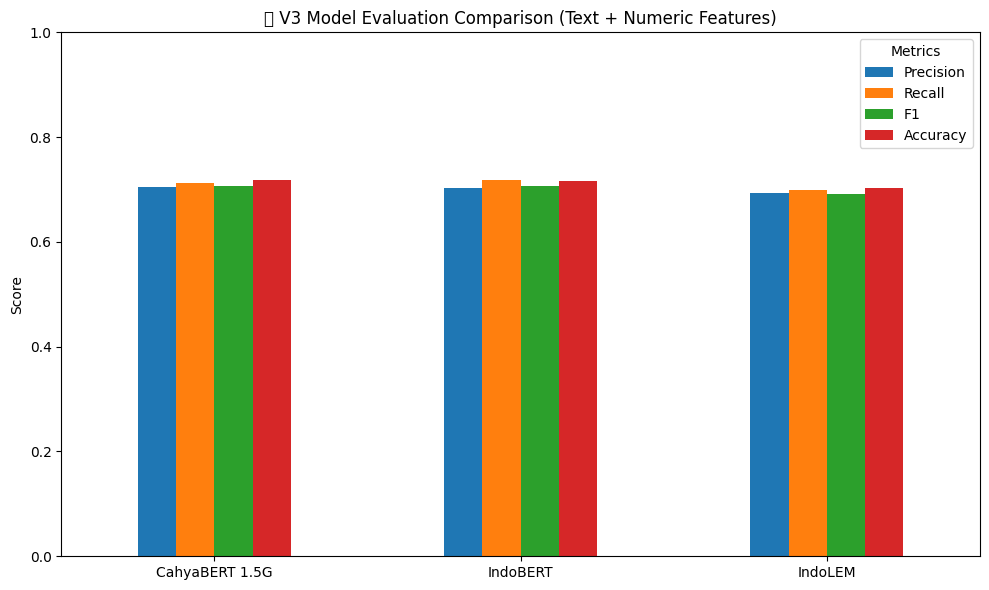

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Define paths to summary files
summary_paths = {
    "CahyaBERT 1.5G": "results/V3_CahyaBERT/summary.csv",
    "IndoBERT": "results/V3_IndoBERT/summary.csv",
    "IndoLEM": "results/V3_IndoLEM/summary.csv"
}

# Load average row from each summary file
summary_data = {}
for model_name, path in summary_paths.items():
    df = pd.read_csv(path)
    average_row = df.iloc[-1].drop(labels="Fold")  # last row = Average
    summary_data[model_name] = average_row.values

# Convert to DataFrame
metrics = ["Precision", "Recall", "F1", "Accuracy"]
comparison_df = pd.DataFrame(summary_data, index=metrics).T

# Display as table
print("\n📊 V3 Model Comparison (Text + Numeric):\n")
print(comparison_df.round(4))

# Plot comparison
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("📈 V3 Model Evaluation Comparison (Text + Numeric Features)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.savefig("results/V3_Model_Comparison.png")
plt.show()


## V4: IndoBERT Contextual Filtered Text + Numerical Features

In [6]:
# === IndoBERT V3: Mentioned Text + Numeric Features + Class Weights ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indobenchmark/indobert-base-p1"
OUTPUT_DIR = "results/V4_IndoBERT"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["bert_context_filtered"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1105, 'grad_norm': 16.374942779541016, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9541, 'grad_norm': 17.591598510742188, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7992, 'grad_norm': 17.62262725830078, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7797985672950745, 'eval_accuracy': 0.6656151419558359, 'eval_f1': 0.6479996954817099, 'eval_precision': 0.6702351485148516, 'eval_recall': 0.6479723713145763, 'eval_runtime': 0.7029, 'eval_samples_per_second': 450.97, 'eval_steps_per_second': 56.905, 'epoch': 1.0}
{'loss': 0.6023, 'grad_norm': 16.077608108520508, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6363, 'grad_norm': 20.167146682739258, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.611, 'grad_norm': 36.91620635986328, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5556563138961792, 'ev

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0642, 'grad_norm': 17.01740264892578, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0095, 'grad_norm': 13.12769603729248, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.7831, 'grad_norm': 14.014555931091309, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7456356287002563, 'eval_accuracy': 0.7287066246056783, 'eval_f1': 0.7293514835169047, 'eval_precision': 0.7372917559206679, 'eval_recall': 0.7516612796633656, 'eval_runtime': 0.7852, 'eval_samples_per_second': 403.705, 'eval_steps_per_second': 50.941, 'epoch': 1.0}
{'loss': 0.6585, 'grad_norm': 20.044452667236328, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5911, 'grad_norm': 29.33022117614746, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5581, 'grad_norm': 11.999958992004395, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8766356110572815, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1079, 'grad_norm': 12.492703437805176, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0083, 'grad_norm': 8.717483520507812, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8423, 'grad_norm': 13.941608428955078, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6550700068473816, 'eval_accuracy': 0.6971608832807571, 'eval_f1': 0.7012476784905918, 'eval_precision': 0.7004373990398834, 'eval_recall': 0.7385195384211908, 'eval_runtime': 0.8337, 'eval_samples_per_second': 380.245, 'eval_steps_per_second': 47.98, 'epoch': 1.0}
{'loss': 0.6563, 'grad_norm': 12.524118423461914, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6167, 'grad_norm': 13.62608528137207, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5419, 'grad_norm': 10.798861503601074, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.556713879108429, 'ev

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.122, 'grad_norm': 15.267339706420898, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0083, 'grad_norm': 12.588491439819336, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8189, 'grad_norm': 13.844664573669434, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.8345460295677185, 'eval_accuracy': 0.6624605678233438, 'eval_f1': 0.6556282230418667, 'eval_precision': 0.6572457919547087, 'eval_recall': 0.6751507998950957, 'eval_runtime': 0.8334, 'eval_samples_per_second': 380.367, 'eval_steps_per_second': 47.996, 'epoch': 1.0}
{'loss': 0.6007, 'grad_norm': 17.168052673339844, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5222, 'grad_norm': 16.342897415161133, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7031, 'grad_norm': 15.577340126037598, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7188544273376465, 

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.11, 'grad_norm': 15.074498176574707, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9578, 'grad_norm': 8.813939094543457, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8936, 'grad_norm': 12.764435768127441, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7290390729904175, 'eval_accuracy': 0.6813880126182965, 'eval_f1': 0.673534343374819, 'eval_precision': 0.6790128719329859, 'eval_recall': 0.6769735116706005, 'eval_runtime': 0.6847, 'eval_samples_per_second': 462.96, 'eval_steps_per_second': 58.418, 'epoch': 1.0}
{'loss': 0.6498, 'grad_norm': 5.592259407043457, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.535, 'grad_norm': 9.94849967956543, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6803, 'grad_norm': 15.497580528259277, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6766148805618286, 'eval_ac

## indobert with large model

In [1]:
# === IndoBERT V3: Mentioned Text + Numeric Features + Class Weights ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indobenchmark/indobert-large-p1" 
OUTPUT_DIR = "results/V4_IndoBERT_LARGE"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["bert_context_filtered"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rayssa\.cache\huggingface\hub\models--indobenchmark--indobert-large-p1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Devel


📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1843, 'grad_norm': 20.522811889648438, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0602, 'grad_norm': 17.748714447021484, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.9506, 'grad_norm': 10.375408172607422, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7588056325912476, 'eval_accuracy': 0.7160883280757098, 'eval_f1': 0.7028468320509513, 'eval_precision': 0.7114767464660187, 'eval_recall': 0.6966951513690532, 'eval_runtime': 2.721, 'eval_samples_per_second': 116.501, 'eval_steps_per_second': 14.7, 'epoch': 1.0}
{'loss': 0.7125, 'grad_norm': 16.923864364624023, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6428, 'grad_norm': 14.53173828125, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7003, 'grad_norm': 38.49872589111328, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6576089859008789, 'eval_a

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1422, 'grad_norm': 16.072519302368164, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0673, 'grad_norm': 16.545530319213867, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.9438, 'grad_norm': 9.831110954284668, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7930976748466492, 'eval_accuracy': 0.6971608832807571, 'eval_f1': 0.6960633031994886, 'eval_precision': 0.7021164078723748, 'eval_recall': 0.7226937968288016, 'eval_runtime': 2.49, 'eval_samples_per_second': 127.308, 'eval_steps_per_second': 16.064, 'epoch': 1.0}
{'loss': 0.7019, 'grad_norm': 12.997179985046387, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.557, 'grad_norm': 21.84099006652832, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5436, 'grad_norm': 15.8812255859375, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7617053389549255, 'eval_

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1106, 'grad_norm': 16.83293914794922, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0733, 'grad_norm': 41.02302932739258, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.9679, 'grad_norm': 9.558772087097168, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.767483115196228, 'eval_accuracy': 0.6277602523659306, 'eval_f1': 0.5999941623842283, 'eval_precision': 0.6585445094217024, 'eval_recall': 0.5994820351429321, 'eval_runtime': 2.8644, 'eval_samples_per_second': 110.669, 'eval_steps_per_second': 13.965, 'epoch': 1.0}
{'loss': 0.7167, 'grad_norm': 11.18734073638916, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6546, 'grad_norm': 18.588314056396484, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5446, 'grad_norm': 14.179547309875488, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.504065215587616, 'eval

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.122, 'grad_norm': 17.454679489135742, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0771, 'grad_norm': 19.78711700439453, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.9543, 'grad_norm': 13.947972297668457, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.835989773273468, 'eval_accuracy': 0.6561514195583596, 'eval_f1': 0.6410580579379593, 'eval_precision': 0.6389000478240077, 'eval_recall': 0.6435385523210071, 'eval_runtime': 2.6762, 'eval_samples_per_second': 118.452, 'eval_steps_per_second': 14.947, 'epoch': 1.0}
{'loss': 0.7308, 'grad_norm': 10.98685359954834, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5894, 'grad_norm': 14.949514389038086, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6826, 'grad_norm': 9.72754955291748, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7166187763214111, 'eval

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1809, 'grad_norm': 18.92430877685547, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0626, 'grad_norm': 15.053174018859863, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.9685, 'grad_norm': 15.700447082519531, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7563915252685547, 'eval_accuracy': 0.6782334384858044, 'eval_f1': 0.6697231421546489, 'eval_precision': 0.6655413625304135, 'eval_recall': 0.6800583530028849, 'eval_runtime': 2.7043, 'eval_samples_per_second': 117.219, 'eval_steps_per_second': 14.791, 'epoch': 1.0}
{'loss': 0.682, 'grad_norm': 7.340860843658447, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5825, 'grad_norm': 11.694058418273926, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6603, 'grad_norm': 10.783377647399902, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6175763607025146, 'e

In [2]:
import os
import shutil

base_path = "results/V4_IndoBERT_LARGE"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 7 checkpoint folders in: results/V4_IndoBERT_LARGE\fold_1
✅ Deleted 4 checkpoint folders in: results/V4_IndoBERT_LARGE\fold_2
✅ Deleted 4 checkpoint folders in: results/V4_IndoBERT_LARGE\fold_3
✅ Deleted 5 checkpoint folders in: results/V4_IndoBERT_LARGE\fold_4
✅ Deleted 4 checkpoint folders in: results/V4_IndoBERT_LARGE\fold_5


In [7]:
import os
import shutil

base_path = "results/V4_IndoBERT"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 4 checkpoint folders in: results/V4_IndoBERT\fold_1
✅ Deleted 3 checkpoint folders in: results/V4_IndoBERT\fold_2
✅ Deleted 6 checkpoint folders in: results/V4_IndoBERT\fold_3
✅ Deleted 8 checkpoint folders in: results/V4_IndoBERT\fold_4
✅ Deleted 7 checkpoint folders in: results/V4_IndoBERT\fold_5


## V4: CahyaBERT Contextual Filtered Text + Numerical Features

In [8]:
# === IndoBERT V3: Mentioned Text + Numeric Features + Class Weights ===

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "cahya/bert-base-indonesian-1.5G"
OUTPUT_DIR = "results/V4_CahyaBERT"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["bert_context_filtered"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1025, 'grad_norm': 13.499939918518066, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9453, 'grad_norm': 13.945780754089355, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8313, 'grad_norm': 13.853926658630371, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7234816551208496, 'eval_accuracy': 0.6876971608832808, 'eval_f1': 0.6796302879488091, 'eval_precision': 0.7064663160114074, 'eval_recall': 0.6932458293771245, 'eval_runtime': 0.8027, 'eval_samples_per_second': 394.893, 'eval_steps_per_second': 49.829, 'epoch': 1.0}
{'loss': 0.5336, 'grad_norm': 16.30808448791504, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6336, 'grad_norm': 17.6890811920166, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6158, 'grad_norm': 18.59699058532715, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5633793473243713, 'ev

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0922, 'grad_norm': 13.378011703491211, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0266, 'grad_norm': 12.59664535522461, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8219, 'grad_norm': 13.720168113708496, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.8257413506507874, 'eval_accuracy': 0.6813880126182965, 'eval_f1': 0.6792773637601224, 'eval_precision': 0.7032581323606295, 'eval_recall': 0.709226780539881, 'eval_runtime': 0.6996, 'eval_samples_per_second': 453.123, 'eval_steps_per_second': 57.176, 'epoch': 1.0}
{'loss': 0.6749, 'grad_norm': 16.093263626098633, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.565, 'grad_norm': 27.511260986328125, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5453, 'grad_norm': 13.385172843933105, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7477670907974243, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1133, 'grad_norm': 12.608789443969727, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0193, 'grad_norm': 9.882536888122559, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8643, 'grad_norm': 17.513830184936523, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6597320437431335, 'eval_accuracy': 0.7160883280757098, 'eval_f1': 0.7158725511184992, 'eval_precision': 0.710200774420958, 'eval_recall': 0.7441712562286913, 'eval_runtime': 0.812, 'eval_samples_per_second': 390.397, 'eval_steps_per_second': 49.261, 'epoch': 1.0}
{'loss': 0.6008, 'grad_norm': 12.311951637268066, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6823, 'grad_norm': 13.067063331604004, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5613, 'grad_norm': 10.773126602172852, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5385318398475647, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.116, 'grad_norm': 13.018996238708496, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9957, 'grad_norm': 13.158970832824707, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8097, 'grad_norm': 11.582206726074219, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7650182843208313, 'eval_accuracy': 0.6971608832807571, 'eval_f1': 0.6788452182963943, 'eval_precision': 0.6767173892238492, 'eval_recall': 0.681372934697089, 'eval_runtime': 0.8273, 'eval_samples_per_second': 383.153, 'eval_steps_per_second': 48.347, 'epoch': 1.0}
{'loss': 0.5562, 'grad_norm': 12.04000186920166, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.4676, 'grad_norm': 35.731651306152344, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6585, 'grad_norm': 10.262194633483887, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7402867674827576, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1107, 'grad_norm': 13.523436546325684, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9937, 'grad_norm': 7.409126281738281, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.86, 'grad_norm': 11.293376922607422, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6855285167694092, 'eval_accuracy': 0.7192429022082019, 'eval_f1': 0.7139936218008325, 'eval_precision': 0.7145242494079703, 'eval_recall': 0.7305992656700759, 'eval_runtime': 0.7058, 'eval_samples_per_second': 449.159, 'eval_steps_per_second': 56.676, 'epoch': 1.0}
{'loss': 0.6477, 'grad_norm': 7.500432968139648, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5433, 'grad_norm': 20.39215660095215, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6107, 'grad_norm': 16.13271141052246, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6791315078735352, 'eval

In [9]:
import os
import shutil

base_path = "results/V4_CahyaBERT"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 6 checkpoint folders in: results/V4_CahyaBERT\fold_1
✅ Deleted 9 checkpoint folders in: results/V4_CahyaBERT\fold_2
✅ Deleted 8 checkpoint folders in: results/V4_CahyaBERT\fold_3
✅ Deleted 5 checkpoint folders in: results/V4_CahyaBERT\fold_4
✅ Deleted 6 checkpoint folders in: results/V4_CahyaBERT\fold_5


## V4: IndoLEM Contextual Filtered Text + Numerical Features

In [10]:

import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "indolem/indobert-base-uncased"
OUTPUT_DIR = "results/V4_IndoLEM"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["bert_context_filtered"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # Predict
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1132, 'grad_norm': 24.286026000976562, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0846, 'grad_norm': 57.722713470458984, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0766, 'grad_norm': 16.99835777282715, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.9907618165016174, 'eval_accuracy': 0.5078864353312302, 'eval_f1': 0.32450104254459117, 'eval_precision': 0.5521600392734413, 'eval_recall': 0.37564287365878374, 'eval_runtime': 0.7948, 'eval_samples_per_second': 398.824, 'eval_steps_per_second': 50.325, 'epoch': 1.0}
{'loss': 1.0374, 'grad_norm': 22.050113677978516, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.8715, 'grad_norm': 19.949190139770508, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8061, 'grad_norm': 18.075605392456055, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.720096230506897,

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1201, 'grad_norm': 28.54863166809082, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1237, 'grad_norm': 28.55632781982422, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.1124, 'grad_norm': 18.432506561279297, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.0245568752288818, 'eval_accuracy': 0.48264984227129337, 'eval_f1': 0.4241739103269995, 'eval_precision': 0.4498978758169934, 'eval_recall': 0.42901897504267783, 'eval_runtime': 0.6728, 'eval_samples_per_second': 471.152, 'eval_steps_per_second': 59.451, 'epoch': 1.0}
{'loss': 1.0493, 'grad_norm': 13.902817726135254, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9343, 'grad_norm': 23.508930206298828, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.7651, 'grad_norm': 18.144498825073242, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7975382208824158,

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1182, 'grad_norm': 39.37967300415039, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.1229, 'grad_norm': 21.105714797973633, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.1116, 'grad_norm': 33.72507095336914, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.015553593635559, 'eval_accuracy': 0.4952681388012618, 'eval_f1': 0.38124698397691575, 'eval_precision': 0.5152518978605936, 'eval_recall': 0.42600642538683453, 'eval_runtime': 0.8298, 'eval_samples_per_second': 382.018, 'eval_steps_per_second': 48.204, 'epoch': 1.0}
{'loss': 1.0374, 'grad_norm': 23.90974235534668, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9622, 'grad_norm': 18.934396743774414, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8154, 'grad_norm': 21.03118896484375, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7290678024291992, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1516, 'grad_norm': 24.287738800048828, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0971, 'grad_norm': 20.5051326751709, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.1163, 'grad_norm': 20.7797908782959, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 1.0536471605300903, 'eval_accuracy': 0.5110410094637224, 'eval_f1': 0.3069430830303919, 'eval_precision': 0.6640091638029783, 'eval_recall': 0.37449514817728824, 'eval_runtime': 0.8461, 'eval_samples_per_second': 374.682, 'eval_steps_per_second': 47.278, 'epoch': 1.0}
{'loss': 1.0637, 'grad_norm': 17.58423614501953, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.9785, 'grad_norm': 14.972084999084473, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.9017, 'grad_norm': 22.665822982788086, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.8073813319206238, 'ev

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.12, 'grad_norm': 47.620689392089844, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0825, 'grad_norm': 19.17879295349121, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 1.0771, 'grad_norm': 13.067580223083496, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.9438492059707642, 'eval_accuracy': 0.580441640378549, 'eval_f1': 0.4666180637054424, 'eval_precision': 0.6166388734482119, 'eval_recall': 0.4718889325990034, 'eval_runtime': 0.7059, 'eval_samples_per_second': 449.065, 'eval_steps_per_second': 56.664, 'epoch': 1.0}
{'loss': 0.9526, 'grad_norm': 16.2506160736084, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.857, 'grad_norm': 19.317922592163086, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.8014, 'grad_norm': 26.606687545776367, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6840112805366516, 'eval_

In [11]:
import os
import shutil

base_path = "results/V4_IndoLEM"

# Loop through each fold
for i in range(1, 6):
    fold_path = os.path.join(base_path, f"fold_{i}")
    deleted = 0

    # Delete folders that start with 'checkpoint'
    for item in os.listdir(fold_path):
        item_path = os.path.join(fold_path, item)
        if os.path.isdir(item_path) and item.startswith("checkpoint"):
            try:
                shutil.rmtree(item_path)
                deleted += 1
            except Exception as e:
                print(f"❌ Failed to delete {item_path}: {e}")

    print(f"✅ Deleted {deleted} checkpoint folders in: {fold_path}")


✅ Deleted 9 checkpoint folders in: results/V4_IndoLEM\fold_1
✅ Deleted 6 checkpoint folders in: results/V4_IndoLEM\fold_2
✅ Deleted 8 checkpoint folders in: results/V4_IndoLEM\fold_3
✅ Deleted 8 checkpoint folders in: results/V4_IndoLEM\fold_4
✅ Deleted 8 checkpoint folders in: results/V4_IndoLEM\fold_5


## model comparison for V4


🏆 V4 Leaderboard (Sorted by F1-score from last row):

                Precision  Recall      F1  Accuracy
CahyaBERT 1.5G     0.7686  0.7747  0.7688    0.7773
IndoBERT           0.7587  0.7670  0.7587    0.7666
IndoLEM            0.7577  0.7624  0.7576    0.7666


C:\Users\rayssa\AppData\Local\Temp\ipykernel_55116\941306491.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rayssa\AppData\Local\Temp\ipykernel_55116\941306491.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("results/V4_Model_Leaderboard_F1.png")
c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


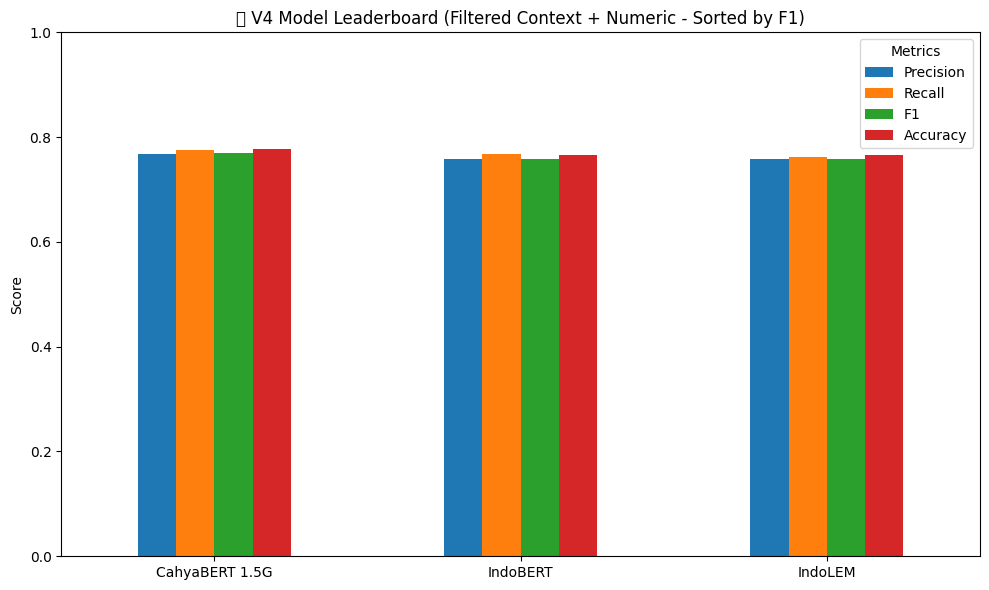

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define paths to summary files
summary_paths = {
    "IndoBERT": "results/V4_IndoBERT/summary.csv",
    "CahyaBERT 1.5G": "results/V4_CahyaBERT/summary.csv",
    "IndoLEM": "results/V4_IndoLEM/summary.csv"
}

summary_data = {}

for model_name, path in summary_paths.items():
    df = pd.read_csv(path)
    last_row = df.iloc[-1].drop(labels="Fold")  # last row = average row
    summary_data[model_name] = last_row

# Create DataFrame
metrics = ["Precision", "Recall", "F1", "Accuracy"]
df_comparison = pd.DataFrame(summary_data, index=metrics).T

# Sort by F1
df_comparison = df_comparison.sort_values(by="F1", ascending=False)

# Display leaderboard
print("\n🏆 V4 Leaderboard (Sorted by F1-score from last row):\n")
print(df_comparison.round(4))

# Plot
df_comparison.plot(kind='bar', figsize=(10, 6))
plt.title("📊 V4 Model Leaderboard (Filtered Context + Numeric - Sorted by F1)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.savefig("results/V4_Model_Leaderboard_F1.png")
plt.show()
